# Extending MNIST task with additional output for Odd/Even

In [1]:
# PyTorch imports
import torch  # Main PyTorch library
import torch.nn as nn  # Neural network modules
import torch.optim as optim  # Optimization algorithms
#import torch.nn.functional as F  # Activation functions and other functional operations

import numpy as np # For matrix operations

# Data handling imports
from torch.utils.data import Dataset, DataLoader, random_split  # For dataset operations and data loading
from torchvision import datasets, transforms  # For vision datasets and image transformations

# Visualization and utility imports
import matplotlib.pyplot as plt  # For plotting graphs and images
import numpy as np  # For numerical operations
from tqdm import tqdm  # For progress bars in loops

In [2]:
# Custom dataset class
class MNISTWithParity(Dataset):
    def __init__(self, mnist_dataset):
        # Initialize the class with the original MNIST dataset
        self.mnist_dataset = mnist_dataset
    
    def __len__(self):
        # Return the length of the dataset
        return len(self.mnist_dataset)
    
    def __getitem__(self, idx):
        # Get an item from the dataset by index
        image, label = self.mnist_dataset[idx]
        
        # Calculate parity (odd/even) of the label
        parity = label % 2  # 0 for even, 1 for odd
        
        # Return the image, and a tuple containing the original label and its parity
        return image, (label, parity)

This custom dataset class, `MNISTWithParity`, extends the functionality of the original MNIST dataset by adding parity information to each sample.

Class Definition

- **`class MNISTWithParity(Dataset):`**
  - Defines a new class that inherits from PyTorch's `Dataset` class.
  - Enables use with PyTorch's `DataLoader` for efficient data handling.

Constructor Method

- **`def __init__(self, mnist_dataset):`**
  - Constructor that takes the original MNIST dataset as a parameter.
  - **`self.mnist_dataset = mnist_dataset`**
    - Stores the original dataset as an attribute for later use.

Length Method

- **`def __len__(self):`**
  - Required by PyTorch's `Dataset` class.
  - **`return len(self.mnist_dataset)`**
    - Returns the total number of samples, matching the original dataset.

Get Item Method

- **`def __getitem__(self, idx):`**
  - Crucial for accessing individual samples.
  - Called by `DataLoader` during training and evaluation.
  - **`image, label = self.mnist_dataset[idx]`**
    - Retrieves the image and label from the original dataset.
  - **`parity = label % 2  # 0 for even, 1 for odd`**
    - Calculates the parity of the digit label (0 for even, 1 for odd).
  - **`return image, (label, parity)`**
    - Returns a tuple of the image and (label, parity) pair.

Usage Implications

- Enables simultaneous training on digit recognition and parity classification.
- Batches will contain images with both digit labels and parity information.
- Models can learn to predict both digit value and parity, potentially enhancing numerical understanding.

In [3]:
# Modified CNN model for digit and parity classification
class DigitParityCNN(nn.Module):
    def __init__(self):
        super(DigitParityCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 3 * 3, 128) # the output of conv3->relu->pool (batch size, 128, 3, 3), after flatten (batch size, 1152)
        self.fc2_digit = nn.Linear(128, 10)  # Digit classification (0-9)
        self.fc2_parity = nn.Linear(128, 2)  # Parity classification (odd/even)
        
        # Additional layers
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

    def forward(self, x):
        # First convolutional block
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # Second convolutional block
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # Third convolutional block
        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # Flatten the output for the fully connected layers
        x = self.flatten(x)
        
        # First fully connected layer
        x = self.fc1(x)
        x = self.relu(x)
        
        # Output layers
        digit_output = self.fc2_digit(x)
        parity_output = self.fc2_parity(x)
        
        return digit_output, parity_output

This `DigitParityCNN` class defines a Convolutional Neural Network (CNN) designed to classify both digits and their parity from MNIST images.

Class Definition

- **`class DigitParityCNN(nn.Module):`**
  - Defines a new neural network class that inherits from PyTorch's `nn.Module`.
  - This inheritance provides essential functionality for PyTorch models.

Constructor Method

- **`def __init__(self):`**
  - Initializes the layers and operations used in the network.
  
  - **Convolutional Layers:**
    - **`self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)`**
      - First convolutional layer: 1 input channel, 32 output channels, 3x3 kernel.
    - **`self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)`**
      - Second convolutional layer: 32 input channels, 64 output channels, 3x3 kernel.
    - **`self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)`**
      - Third convolutional layer: 64 input channels, 128 output channels, 3x3 kernel.
  
  - **Fully Connected Layers:**
    - **`self.fc1 = nn.Linear(128 * 3 * 3, 128)`**
      - First fully connected layer: flattened conv output to 128 neurons.
    - **`self.fc2_digit = nn.Linear(128, 10)`**
      - Output layer for digit classification (10 classes).
    - **`self.fc2_parity = nn.Linear(128, 2)`**
      - Output layer for parity classification (2 classes: odd/even).
  
  - **Other Layers:**
    - **`self.pool = nn.MaxPool2d(2, 2)`**
      - Max pooling layer with 2x2 kernel and stride 2.
    - **`self.relu = nn.ReLU()`**
      - ReLU activation function.
    - **`self.flatten = nn.Flatten()`**
      - Flattens the 3D output from convolutional layers to 1D.

Forward Method

- **`def forward(self, x):`**
  - Defines the forward pass of the network.
  
  - **First Convolutional Block:**
    ```python
    x = self.conv1(x)
    x = self.relu(x)
    x = self.pool(x)
    ```
    Applies convolution, ReLU activation, and max pooling.
  
  - **Second Convolutional Block:**
    ```python
    x = self.conv2(x)
    x = self.relu(x)
    x = self.pool(x)
    ```
    Repeats the process with the second convolutional layer.
  
  - **Flatten and Fully Connected Layers:**
    ```python
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.relu(x)
    ```
    Flattens the output, passes through the first fully connected layer, and applies ReLU.
  
  - **Output Layers:**
    ```python
    digit_output = self.fc2_digit(x)
    parity_output = self.fc2_parity(x)
    ```
    Produces separate outputs for digit and parity classification.
  
  - **`return digit_output, parity_output`**
    - Returns both outputs as a tuple.

Network Architecture Summary

1. Input: MNIST image (1x28x28)
2. Two convolutional layers with ReLU and max pooling
3. Flattening of the 2D feature maps
4. One hidden fully connected layer
5. Two parallel output layers for digit and parity classification

This architecture allows the network to simultaneously learn features relevant for both digit recognition and parity determination, potentially leveraging shared representations for both tasks.

In [4]:
# Hyperparameters
batch_size = 64        # Number of samples processed before the model is updated
learning_rate = 0.001  # Step size at each iteration while moving toward a minimum of the loss function
num_epochs = 5         # Number of complete passes through the training dataset
validation_split = 0.1 # Fraction of the training data to be used as validation data

Batch Size

- **`batch_size = 64`**
  - Defines the number of samples processed before the model's internal parameters are updated.
  - Implications:
    - Larger batch sizes can lead to faster training but may require more memory.
    - Smaller batch sizes can provide a regularizing effect and may help the model generalize better.
    - A batch size of 64 is a common choice, balancing between computational efficiency and generalization.

Learning Rate

- **`learning_rate = 0.001`**
  - Determines the step size at each iteration while moving toward a minimum of the loss function.
  - Implications:
    - A learning rate of 0.001 is a common starting point for the Adam optimizer.
    - Too high: May cause the model to overshoot the optimal point.
    - Too low: May result in slow convergence or getting stuck in local minima.
    - The chosen value (0.001) aims to provide a balance between learning speed and stability.

Number of Epochs

- **`num_epochs = 5`**
  - Specifies the number of complete passes through the entire training dataset.
  - Implications:
    - More epochs allow the model more opportunities to learn from the data.
    - Too few epochs might lead to underfitting.
    - Too many epochs could cause overfitting or unnecessary computation if the model has already converged.
    - 5 epochs suggest a relatively short training process, which might be suitable for quick experiments or if the model converges rapidly.

Validation Split

- **`validation_split = 0.1`**
  - Determines the fraction of the training data to be used as the validation set.
  - Implications:
    - 10% of the training data will be used for validation.
    - Helps in monitoring the model's performance on unseen data during training.
    - Aids in detecting overfitting and in hyperparameter tuning.
    - A 90-10 split is common, providing a good balance between training data size and validation set representativeness.

Collective Impact

- These hyperparameters work together to influence the training dynamics:
  - The combination of batch size and learning rate affects the stability and speed of convergence.
  - The number of epochs and validation split help in monitoring and controlling the training process to achieve optimal performance without overfitting.
- Adjusting these values can significantly impact the model's learning process and final performance.

In [5]:
# Data loading and preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize with MNIST mean and std dev
])

This code snippet defines a transformation pipeline for preprocessing the MNIST dataset.

`transforms.Compose`

- **Purpose:** Creates a composition of multiple transforms.
- **Functionality:** Allows chaining of several image transformations that will be applied sequentially to the input data.

Transformation Pipeline

1. `transforms.ToTensor()`

- **Purpose:** Converts a PIL Image or numpy.ndarray to a torch.FloatTensor.
- **Functionality:**
  - Converts the image to a PyTorch tensor.
  - Scales the image's pixel values to the range [0, 1].
- **Importance:** 
  - PyTorch models operate on tensors, making this conversion necessary.
  - Scaling to [0, 1] is a common preprocessing step that helps in numerical stability during training.

2. `transforms.Normalize((0.1307,), (0.3081,))`

- **Purpose:** Normalizes a tensor image with mean and standard deviation.
- **Parameters:**
  - `(0.1307,)`: The mean value for normalization.
  - `(0.3081,)`: The standard deviation for normalization.
- **Functionality:**
  - For each channel in the image, subtracts the mean and divides by the standard deviation.
  - Formula: `output = (input - mean) / std`
- **Importance:**
  - These specific values (0.1307, 0.3081) are the precomputed mean and standard deviation of the MNIST dataset.
  - Normalization centers the data around zero and scales it to a common range, which can help in faster convergence during training.

Why These Specific Values?

- **Mean (0.1307):** Represents the average pixel intensity across all MNIST images.
- **Standard Deviation (0.3081):** Represents the average variation in pixel intensities.
- Using these dataset-specific values ensures that the normalization is tailored to the characteristics of MNIST images.

Benefits of This Preprocessing

1. **Consistency:** Ensures all images are in a consistent format (PyTorch tensors).
2. **Numerical Stability:** Scaling to [0, 1] and then normalizing helps prevent issues with very large or small values during computations.
3. **Improved Training Dynamics:** Normalized inputs can lead to faster convergence during the training process.
4. **Model Generalization:** Helps the model focus on the relative differences in pixel intensities rather than absolute values.

Usage

This `transform` object will typically be passed to a PyTorch `Dataset` or `DataLoader`, which will apply these transformations to each image as it's loaded. For example:

```python
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
```

This ensures that all images fed into the model undergo consistent preprocessing, crucial for the model's performance and generalization capabilities.

In [6]:
# Load the MNIST dataset
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Create a custom dataset that includes parity information
custom_dataset = MNISTWithParity(mnist_dataset)

This code snippet demonstrates the creation of the MNIST dataset and its customization to include parity information.

1. Creating the MNIST Dataset

```python
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
```

Parameters:

- **`root='./data'`**: 
  - Specifies the directory where the MNIST dataset will be stored.
  - If the dataset doesn't exist in this directory, it will be downloaded here.

- **`train=True`**: 
  - Indicates that we're loading the training set of MNIST.
  - The training set contains 60,000 images.
  - Setting this to `False` would load the test set (10,000 images).

- **`download=True`**: 
  - Allows the method to download the dataset if it's not already present in the specified `root` directory.
  - If the dataset is already downloaded, this parameter has no effect.

- **`transform=transform`**: 
  - Applies the previously defined `transform` to each image in the dataset.
  - This ensures all images undergo the same preprocessing steps (conversion to tensor and normalization).

Functionality:

- Creates a PyTorch dataset object containing the MNIST training images.
- Each item in this dataset is a tuple of (image, label), where:
  - `image` is a preprocessed tensor representation of the handwritten digit.
  - `label` is an integer from 0 to 9 representing the digit.

2. Creating the Custom Dataset

```python
custom_dataset = MNISTWithParity(mnist_dataset)
```

- Wraps the standard MNIST dataset with our custom `MNISTWithParity` class.
- Enhances each sample with parity information (odd/even) derived from the digit label.

Functionality:

- Creates a new dataset object that inherits from the original MNIST dataset.
- Modifies the `__getitem__` method to return a tuple of (image, (label, parity)) for each sample, where:
  - `image` remains the same preprocessed tensor from the original dataset.
  - `label` is still the original digit (0-9).
  - `parity` is a new binary value (0 for even, 1 for odd) derived from the label.

Implications and Benefits:

1. **Data Augmentation**: 
   - Adds parity information without altering the original images or labels.
   - Enables multi-task learning (digit classification and parity determination) from the same dataset.

2. **Efficiency**: 
   - Reuses the existing MNIST dataset, avoiding duplicate storage of images.
   - Parity is computed on-the-fly, adding minimal overhead to data loading.

3. **Flexibility**: 
   - The custom dataset can be easily used with PyTorch's `DataLoader` for batch processing.
   - Allows for easy extension to include other derived features in the future.

4. **Consistency**: 
   - Ensures that the parity information is always correctly aligned with the corresponding digit label.

5. **Training Implications**: 
   - Models trained on this dataset will learn to simultaneously recognize digits and determine their parity.
   - This dual task might lead to more robust feature learning in the neural network.

By creating this custom dataset, we've enhanced the MNIST data with additional information.

In [7]:
# Split dataset into training and validation sets
train_size = int((1 - validation_split) * len(custom_dataset))
val_size = len(custom_dataset) - train_size
train_dataset, val_dataset = random_split(custom_dataset, [train_size, val_size])

# Create data loaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

This code snippet demonstrates the process of splitting the custom MNIST dataset into training and validation sets, and creating DataLoader objects for efficient batch processing.

1. Calculating Split Sizes

```python
train_size = int((1 - validation_split) * len(custom_dataset))
val_size = len(custom_dataset) - train_size
```

- **Purpose**: Determine the number of samples for training and validation sets.
- **Functionality**:
  - `validation_split` (e.g., 0.1) specifies the proportion of data for validation.
  - `train_size` calculates the number of samples for training.
  - `val_size` calculates the remaining samples for validation.
- **Importance**:
  - Ensures a proper split according to the specified `validation_split`.
  - Maintains the total dataset size by using complementary proportions.

2. Splitting the Dataset

```python
train_dataset, val_dataset = random_split(custom_dataset, [train_size, val_size])
```

- **Purpose**: Divide the dataset into separate training and validation sets.
- **Functionality**:
  - `random_split` function randomly splits the dataset into two subsets.
  - Ensures random distribution of samples between training and validation sets.
- **Importance**:
  - Prevents data leakage between training and validation.
  - Allows for unbiased evaluation of model performance on unseen data.

3. Creating DataLoaders

```python
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
```

Training DataLoader

- **Parameters**:
  - `dataset=train_dataset`: Uses the training portion of the split dataset.
  - `batch_size=batch_size`: Specifies the number of samples per batch.
  - `shuffle=True`: Randomizes the order of samples in each epoch.
- **Importance**:
  - Shuffling helps prevent the model from learning the order of training samples.
  - Improves generalization by exposing the model to different sample orders across epochs.

Validation DataLoader

- **Parameters**:
  - `dataset=val_dataset`: Uses the validation portion of the split dataset.
  - `batch_size=batch_size`: Keeps the same batch size as training for consistency.
  - `shuffle=False`: Maintains a consistent order for validation samples.
- **Importance**:
  - Consistent ordering allows for reproducible validation results.
  - No need to shuffle as the validation set is used only for evaluation, not training.

Implications and Benefits

1. **Efficient Data Handling**:
   - DataLoaders enable efficient loading of data in batches, optimizing memory usage and processing speed.

2. **Automatic Batching**:
   - Simplifies the training loop by automatically creating batches of the specified size.

3. **Built-in Shuffling**:
   - Improves model robustness by presenting data in different orders during training.

4. **Separate Validation Set**:
   - Allows for unbiased evaluation of model performance on unseen data.
   - Helps in early stopping and hyperparameter tuning.

5. **Scalability**:
   - This approach easily scales to larger datasets and different batch sizes.

6. **Multi-threading Support**:
   - DataLoaders can utilize multiple CPU threads for data loading, potentially speeding up training.

By splitting the dataset and using DataLoaders, we ensure efficient, randomized training and consistent validation.

In [8]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Initialize the model and move it to the appropriate device (GPU or CPU)
model = DigitParityCNN().to(device)

cuda


This code snippet is crucial for setting up the computational device and initializing the model.

1. Device Configuration

```python
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
```

- Determines the appropriate computational device for training the neural network.

Functionality:
- `torch.device()`: Creates a PyTorch device object.
- `cuda if torch.cuda.is_available() else 'cpu'`:
  - Checks if a CUDA-enabled GPU is available.
  - If available, sets the device to 'cuda' (GPU).
  - If not available, falls back to 'cpu'.

Importance:
1. **Flexibility**: Allows the code to run on machines with or without a GPU.
2. **Performance**: Utilizing a GPU can significantly speed up training, especially for large models or datasets.
3. **Compatibility**: Ensures the code works across different hardware setups without modification.

2. Model Initialization

```python
model = DigitParityCNN().to(device)
```

- Creates an instance of the `DigitParityCNN` model and moves it to the appropriate device.

Breakdown:
- `DigitParityCNN()`: Instantiates the custom CNN model we defined earlier.
- `.to(device)`: Moves the model to the specified device (GPU or CPU).

By configuring the device and initializing the model in this way, we ensure that our training process is optimized for the available hardware.

In [9]:
# Loss and optimizer setup
# Loss function for digit classification
criterion_digit = nn.CrossEntropyLoss()

# Loss function for parity classification
criterion_parity = nn.CrossEntropyLoss()

# Adam optimizer for updating model parameters
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

This code snippet sets up the loss functions, optimizer, and learning rate scheduler for training the neural network.

1. Loss Functions

```python
criterion_digit = nn.CrossEntropyLoss()
criterion_parity = nn.CrossEntropyLoss()
```

- Define the loss functions for both digit classification and parity determination tasks.

Functionality:
- `nn.CrossEntropyLoss()`: 
  - Combines `nn.LogSoftmax()` and `nn.NLLLoss()` in one single class.
  - Appropriate for multi-class classification problems.

Importance:
- **Multi-task Learning**: Separate loss functions allow independent evaluation of performance on each task.
- **Simplicity**: CrossEntropyLoss is well-suited for classification tasks and doesn't require manual computation of softmax.
- **Numerical Stability**: Internally uses log-softmax, which is more numerically stable than a simple softmax.

2. Optimizer

```python
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
```

- Defines the optimization algorithm used to update the model's parameters during training.

Components:
- `optim.Adam`: An adaptive learning rate optimization algorithm.
- `model.parameters()`: Specifies that all parameters of the model should be optimized.
- `lr=learning_rate`: Sets the initial learning rate (defined earlier in hyperparameters).

Importance:
- **Adaptive Learning**: Adam adapts the learning rate for each parameter, which can lead to faster convergence.
- **Momentum**: Incorporates momentum-like behavior, helping to overcome local minima.
- **Efficiency**: Generally performs well across a wide range of problems with little parameter tuning.

3. Learning Rate Scheduler

```python
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
```

- Adjusts the learning rate during training to improve convergence and final performance.

Parameters:
- `optimizer`: The optimizer whose learning rate will be adjusted.
- `step_size=1`: Number of epochs between learning rate adjustments.
- `gamma=0.5`: Multiplicative factor of learning rate decay.

Functionality:
- Reduces the learning rate by half (gamma=0.5) every epoch (step_size=1).

Implications and Best Practices

1. **Loss Combination**: 
   - When training, you'll need to combine the digit and parity losses, e.g., `total_loss = loss_digit + loss_parity`.

2. **Monitoring**: 
   - Track both losses separately to understand the model's performance on each task.

3. **Learning Rate Dynamics**:
   - The initial learning rate (set in `optimizer`) will be halved every epoch due to the scheduler.
   - Monitor this to ensure the learning rate doesn't become too small too quickly.

4. **Scheduler Usage**:
   - Remember to call `scheduler.step()` at the end of each epoch during training.

5. **Flexibility**:
   - This setup allows for easy modification, such as using different loss functions or optimizers if needed.

6. **Multi-task Balancing**:
   - You might need to adjust the relative weights of the digit and parity losses if one task dominates the training.


Epoch [1/5], Train Loss: 0.2309, Val Loss: 0.1143
Train Digit Acc: 95.11%, Train Parity Acc: 97.15%
Val Digit Acc: 98.37%, Val Parity Acc: 98.37%


Epoch [2/5], Train Loss: 0.0540, Val Loss: 0.0731
Train Digit Acc: 98.92%, Train Parity Acc: 99.31%
Val Digit Acc: 98.53%, Val Parity Acc: 98.92%


Epoch [3/5], Train Loss: 0.0300, Val Loss: 0.0528
Train Digit Acc: 99.38%, Train Parity Acc: 99.65%
Val Digit Acc: 98.90%, Val Parity Acc: 99.22%


Epoch [4/5], Train Loss: 0.0199, Val Loss: 0.0438
Train Digit Acc: 99.61%, Train Parity Acc: 99.81%
Val Digit Acc: 99.08%, Val Parity Acc: 99.28%


Epoch [5/5], Train Loss: 0.0141, Val Loss: 0.0447
Train Digit Acc: 99.75%, Train Parity Acc: 99.88%
Val Digit Acc: 99.10%, Val Parity Acc: 99.32%


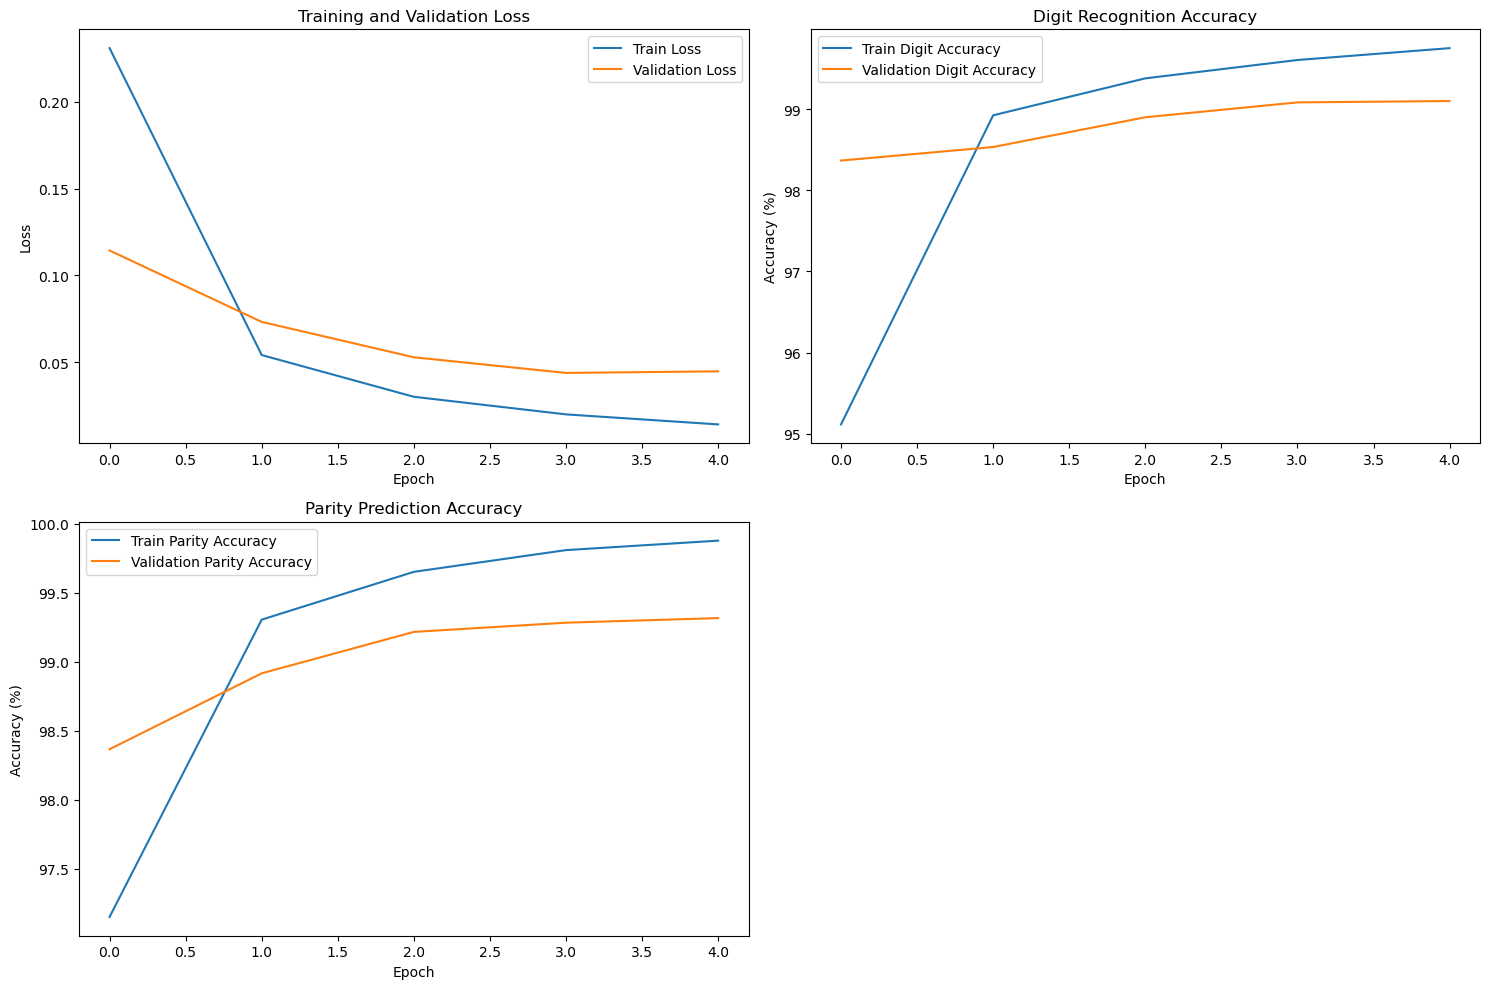

In [10]:
# Initialize lists to store training and validation metrics
train_losses, val_losses = [], []
train_digit_accuracies, train_parity_accuracies = [], []
val_digit_accuracies, val_parity_accuracies = [], []

# Initialize variables for tracking the best model
best_val_loss = float('inf')
best_model_path = 'best_model_digit_parity.pth'

# Main training loop
for epoch in range(num_epochs):
    # Set model to training mode (enables dropout, batch normalization, etc.)
    model.train()
    
    # Initialize metrics for this epoch
    running_loss = 0.0
    correct_digits, correct_parities, total = 0, 0, 0
    
    # Create a progress bar for the training data
    train_loader_tqdm = tqdm(train_loader, desc=f'Epoch [{epoch+1}/{num_epochs}] - Training', leave=False, ascii=True)
    
    # Iterate over batches in the training data
    for images, (labels, parities) in train_loader_tqdm:
        # Move the batch data to the appropriate device (GPU if available, else CPU)
        images, labels, parities = images.to(device), labels.to(device), parities.to(device)
        
        # Zero out the gradients from the previous batch
        optimizer.zero_grad()
        
        # Forward pass: compute the model output for both digit and parity
        digit_outputs, parity_outputs = model(images)
        
        # Compute the loss for digit classification and parity prediction
        loss_digit = criterion_digit(digit_outputs, labels)
        loss_parity = criterion_parity(parity_outputs, parities)
        # Combine the losses (you might want to weight these differently)
        loss = loss_digit + loss_parity
        
        # Backward pass: compute gradients
        loss.backward()
        
        # Update model parameters
        optimizer.step()
        
        # Accumulate the batch loss
        running_loss += loss.item()
        
        # Compute accuracies for this batch
        _, predicted_digits = torch.max(digit_outputs, 1)
        _, predicted_parities = torch.max(parity_outputs, 1)
        total += labels.size(0)
        correct_digits += (predicted_digits == labels).sum().item()
        correct_parities += (predicted_parities == parities).sum().item()
        
        # Update the progress bar with the current batch loss
        train_loader_tqdm.set_postfix({'Train Loss': f'{loss.item():8.4f}'})
    
    # Compute average loss and accuracies for this epoch
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_digit_accuracy = 100 * correct_digits / total
    train_parity_accuracy = 100 * correct_parities / total
    train_digit_accuracies.append(train_digit_accuracy)
    train_parity_accuracies.append(train_parity_accuracy)
    
    # Validation Phase
    # Set model to evaluation mode (disables dropout, batch normalization, etc.)
    model.eval()
    
    # Initialize metrics for validation
    val_loss = 0.0
    correct_digits, correct_parities, total = 0, 0, 0
    
    # Create a progress bar for the validation data
    val_loader_tqdm = tqdm(val_loader, desc=f'Epoch [{epoch+1}/{num_epochs}] - Validation', leave=False, ascii=True)
    
    # Disable gradient computation for validation (saves memory and computations)
    with torch.no_grad():
        for images, (labels, parities) in val_loader_tqdm:
            # Move the batch data to the appropriate device
            images, labels, parities = images.to(device), labels.to(device), parities.to(device)
            
            # Forward pass: compute the model output for both digit and parity
            digit_outputs, parity_outputs = model(images)
            
            # Compute the loss for digit classification and parity prediction
            loss_digit = criterion_digit(digit_outputs, labels)
            loss_parity = criterion_parity(parity_outputs, parities)
            loss = loss_digit + loss_parity
            val_loss += loss.item()
            
            # Compute accuracies for this batch
            _, predicted_digits = torch.max(digit_outputs, 1)
            _, predicted_parities = torch.max(parity_outputs, 1)
            total += labels.size(0)
            correct_digits += (predicted_digits == labels).sum().item()
            correct_parities += (predicted_parities == parities).sum().item()
            
            # Update the progress bar with the current batch loss
            val_loader_tqdm.set_postfix({'Val Loss': f"{loss.item():8.4f}"})
    
    # Compute average validation loss and accuracies for this epoch
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_digit_accuracy = 100 * correct_digits / total
    val_parity_accuracy = 100 * correct_parities / total
    val_digit_accuracies.append(val_digit_accuracy)
    val_parity_accuracies.append(val_parity_accuracy)
    
    # Print the results for this epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    print(f'Train Digit Acc: {train_digit_accuracy:.2f}%, Train Parity Acc: {train_parity_accuracy:.2f}%')
    print(f'Val Digit Acc: {val_digit_accuracy:.2f}%, Val Parity Acc: {val_parity_accuracy:.2f}%')
    
    # Save the best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'best_val_loss': best_val_loss,
        }, best_model_path)
    
    # Step the learning rate scheduler
    scheduler.step()

# Visualization of training results
plt.figure(figsize=(15, 10))

# Plot 1: Training and Validation Loss
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot 2: Digit Recognition Accuracy
plt.subplot(2, 2, 2)
plt.plot(train_digit_accuracies, label='Train Digit Accuracy')
plt.plot(val_digit_accuracies, label='Validation Digit Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Digit Recognition Accuracy')

# Plot 3: Parity Prediction Accuracy
plt.subplot(2, 2, 3)
plt.plot(train_parity_accuracies, label='Train Parity Accuracy')
plt.plot(val_parity_accuracies, label='Validation Parity Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Parity Prediction Accuracy')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

This code snippet represents the core training loop and validation process for the neural network.

Initialization

- `train_losses` and `val_losses`: Lists to store training and validation losses for each epoch.
- `best_val_loss = float('inf')`: Tracks the best validation loss, initialized to infinity.
- `best_model_path`: Specifies where to save the best model checkpoint.

Training Loop

The main loop iterates through `num_epochs`, performing training and validation in each epoch.

Training Phase

1. `model.train()`: Sets the model to training mode, enabling gradients.
2. Iteration through batches:
   - Move data to the appropriate device (CPU/GPU).
   - `optimizer.zero_grad()`: Clears previous gradients.
   - Forward pass: `digit_outputs, parity_outputs = model(images)`
   - Loss computation: Combines losses for digit and parity predictions.
   - `loss.backward()`: Computes gradients.
   - `optimizer.step()`: Updates model parameters.
   - Progress tracking with tqdm.

Validation Phase

1. `model.eval()`: Sets the model to evaluation mode, disabling gradients.
2. `with torch.no_grad()`: Disables gradient computation for efficiency.
3. Similar process to training, but without parameter updates.
4. Accumulates validation loss.

Post-Epoch Processing

1. Prints epoch summary with training and validation losses.
2. Model Checkpoint:
   - Saves the model if it achieves the best validation loss.
   - Stores model state, optimizer state, scheduler state, and loss information.
3. `scheduler.step()`: Adjusts the learning rate according to the scheduler.

Visualization

After training, plots the training and validation losses over epochs.

Potential Enhancements

1. Early Stopping: Could be implemented to prevent overfitting.
2. Gradient Clipping: Might be added to prevent exploding gradients.
3. Separate Accuracy Tracking: Could track accuracy for digit and parity tasks separately.
4. Learning Rate Logging: Monitoring the changing learning rate could provide insights.

In [11]:
# Load the best model for testing

# Load the MNIST test dataset
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Wrap the MNIST test dataset with our custom MNISTWithParity dataset
# This adds parity information to each sample
test_dataset = MNISTWithParity(test_dataset)

# Create a DataLoader for the test dataset
# We use shuffle=False for testing to maintain the original order of the dataset
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load the saved checkpoint of the best model
# This checkpoint was saved during training when the model achieved the lowest validation loss
checkpoint = torch.load(best_model_path)

# Restore the model's state from the checkpoint
# This sets the model's parameters to the values that achieved the best validation performance
model.load_state_dict(checkpoint['model_state_dict'])

# Set the model to evaluation mode
# This disables dropout and sets batch normalization to use running statistics
model.eval()

D:\Temp\ipykernel_19036\1892745261.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_model_path)


DigitParityCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1152, out_features=128, bias=True)
  (fc2_digit): Linear(in_features=128, out_features=10, bias=True)
  (fc2_parity): Linear(in_features=128, out_features=2, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

This code snippet prepares the environment for testing the trained model on unseen data.

1. Loading the Test Dataset

```python
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
```

- Loads the MNIST test dataset.

Parameters:
- `root='./data'`: Directory to store the dataset.
- `train=False`: Specifies that we want the test set, not the training set.
- `download=True`: Downloads the dataset if not already present.
- `transform=transform`: Applies the same transformations used during training.

2. Applying Custom Dataset Wrapper

```python
test_dataset = MNISTWithParity(test_dataset)
```

- Wraps the test dataset with our custom `MNISTWithParity` class.


- Adds parity information to each sample, just like in the training set.


- Allows testing of both digit classification and parity prediction tasks.
- Ensures consistency between training and testing data structures.

3. Creating the Test DataLoader

```python
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
```

- Creates a DataLoader for efficient batching of test data.

Parameters:
- `batch_size=batch_size`: Uses the same batch size as in training.
- `shuffle=False`: Keeps the order of test samples consistent across runs.

4. Loading the Best Model Checkpoint

```python
checkpoint = torch.load(best_model_path)
```

- Loads the saved checkpoint of the best performing model.

Functionality:
- `torch.load()`: Deserializes the saved model file.
- `best_model_path`: Path to the file containing the best model state.


5. Restoring Model State

```python
model.load_state_dict(checkpoint['model_state_dict'])
```

- Restores the model's learned parameters from the checkpoint.

Functionality:
- `load_state_dict()`: Populates the model with the saved parameters.
- `checkpoint['model_state_dict']`: Contains the saved model parameters.

6. Setting Model to Evaluation Mode

```python
model.eval()
```

- Sets the model to evaluation mode.

- Disables dropout layers.
- Critical for getting accurate test results.

In [12]:
def confusion_matrix(y_true, y_pred, num_classes):
    # Initialize a zero-filled matrix of size num_classes x num_classes
    # np.zeros creates a 2D array filled with zeros
    # The shape is (num_classes, num_classes)
    # dtype=int specifies that the array should contain integers
    cm = np.zeros((num_classes, num_classes), dtype=int)
    
    # Iterate through true and predicted labels simultaneously
    # zip(y_true, y_pred) pairs up corresponding elements from y_true and y_pred
    for true, pred in zip(y_true, y_pred):
        # Increment the count at the corresponding position in the matrix
        # true is used as the row index, pred as the column index
        # += 1 increments the count by 1 for each occurrence
        cm[true][pred] += 1
    
    # Return the completed confusion matrix
    # After all iterations, cm contains the counts of all (true, predicted) combinations
    return cm

In [13]:
def plot_confusion_matrix(cm, title, labels=None):
    # Create a new figure and axis with specified size
    fig, ax = plt.subplots(figsize=(6, 5))
    
    # Display the confusion matrix as an image
    # 'nearest' interpolation means no interpolation between pixels
    # plt.cm.Blues is a blue color map
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    
    # Add a colorbar to the plot, using the current axes
    ax.figure.colorbar(im, ax=ax)
    
    # Set various properties of the axis
    ax.set(
        xticks=np.arange(cm.shape[1]),  # Set x-axis ticks to match matrix columns
        yticks=np.arange(cm.shape[0]),  # Set y-axis ticks to match matrix rows
        title=title,  # Set the title of the plot
        ylabel='True label',  # Label for y-axis
        xlabel='Predicted label'  # Label for x-axis
    )
    
    # If labels are provided, use them for x and y axis
    if labels:
        ax.set_xticklabels(labels)  # Set labels for x-axis ticks
        ax.set_yticklabels(labels)  # Set labels for y-axis ticks
    
    # Rotate the tick labels on x-axis and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Calculate threshold for text color (white or black)
    # Values above thresh will be white, below will be black
    thresh = cm.max() / 2.
    
    # Add text annotations to each cell in the plot
    for i in range(cm.shape[0]):  # Iterate over rows
        for j in range(cm.shape[1]):  # Iterate over columns
            # Add text annotation for each cell
            ax.text(j, i, format(cm[i, j], 'd'),  # Position and value to display
                    ha="center", va="center",  # Center alignment
                    color="white" if cm[i, j] > thresh else "black")  # Choose text color based on cell value
    
    # Adjust the layout to prevent clipping of tick-labels
    fig.tight_layout()
    
    # Return the figure object
    return fig

In [14]:
def test_model(model, test_loader, device, criterion_digit, criterion_parity):
    # Set the model to evaluation mode (disables dropout, etc.)
    model.eval()
    
    # Initialize variables to track test performance
    test_loss = 0.0  # Accumulator for total test loss
    correct_digit = 0  # Counter for correct digit predictions
    correct_parity = 0  # Counter for correct parity predictions
    total = 0  # Counter for total number of samples
    
    # Lists to store all predictions and true labels
    all_digit_preds = []  # Stores all digit predictions
    all_digit_labels = []  # Stores all true digit labels
    all_parity_preds = []  # Stores all parity predictions
    all_parity_labels = []  # Stores all true parity labels
    
    # Lists to store misclassified samples
    misclassified_images = []  # Stores misclassified images
    misclassified_labels = []  # Stores true labels of misclassified samples
    misclassified_preds = []  # Stores predictions of misclassified samples
    
    # Create a progress bar for the test loader
    test_loader_tqdm = tqdm(test_loader, desc="Testing", leave=False, ascii=True)
    
    # Disable gradient computation to save memory and computations
    with torch.no_grad():
        # Iterate over batches in the test loader
        for images, (labels, parities) in test_loader_tqdm:
            # Move batch data to the specified device (CPU/GPU)
            images, labels, parities = images.to(device), labels.to(device), parities.to(device)
            
            # Forward pass: compute model outputs
            digit_outputs, parity_outputs = model(images)
            
            # Compute loss for digit classification
            loss_digit = criterion_digit(digit_outputs, labels)
            # Compute loss for parity classification
            loss_parity = criterion_parity(parity_outputs, parities)
            # Combine losses
            loss = loss_digit + loss_parity
            
            # Accumulate total test loss
            test_loss += loss.item()
            
            # Get predicted classes for digits
            _, predicted_digit = torch.max(digit_outputs.data, 1)
            # Get predicted classes for parity
            _, predicted_parity = torch.max(parity_outputs.data, 1)
            
            # Update total sample count
            total += labels.size(0)
            # Update count of correct digit predictions
            correct_digit += (predicted_digit == labels).sum().item()
            # Update count of correct parity predictions
            correct_parity += (predicted_parity == parities).sum().item()
            
            # Extend lists with batch predictions and labels for digits
            all_digit_preds.extend(predicted_digit.cpu().numpy())
            all_digit_labels.extend(labels.cpu().numpy())
            # Extend lists with batch predictions and labels for parity
            all_parity_preds.extend(predicted_parity.cpu().numpy())
            all_parity_labels.extend(parities.cpu().numpy())
            
            # Collect misclassified samples
            for i in range(len(labels)):
                if predicted_digit[i] != labels[i] or predicted_parity[i] != parities[i]:
                    misclassified_images.append(images[i].cpu())
                    misclassified_labels.append((labels[i].cpu(), parities[i].cpu()))
                    misclassified_preds.append((predicted_digit[i].cpu(), predicted_parity[i].cpu()))
    
    # Compute average test loss
    test_loss /= len(test_loader)
    # Compute accuracy for digit classification
    accuracy_digit = 100 * correct_digit / total
    # Compute accuracy for parity classification
    accuracy_parity = 100 * correct_parity / total
    
    # Print test results
    print(f'Test Loss: {test_loss:.4f}, Digit Accuracy: {accuracy_digit:.2f}%, Parity Accuracy: {accuracy_parity:.2f}%')
    
    # Create confusion matrix for digit classification
    cm_digit = confusion_matrix(all_digit_labels, all_digit_preds, num_classes=10)
    # Create confusion matrix for parity classification
    cm_parity = confusion_matrix(all_parity_labels, all_parity_preds, num_classes=2)
    
    # Plot confusion matrix for digit classification
    plot_confusion_matrix(cm_digit, 'Digit Confusion Matrix', labels=range(10))
    # Create a new figure for the parity confusion matrix
    plt.figure()
    # Plot confusion matrix for parity classification
    plot_confusion_matrix(cm_parity, 'Parity Confusion Matrix', labels=['Even', 'Odd'])
    # Display both confusion matrices
    plt.show()
    
    # Return test results and misclassified samples
    return test_loss, accuracy_digit, accuracy_parity, misclassified_images, misclassified_labels, misclassified_preds

Test Loss: 0.0348, Digit Accuracy: 99.17%, Parity Accuracy: 99.58%


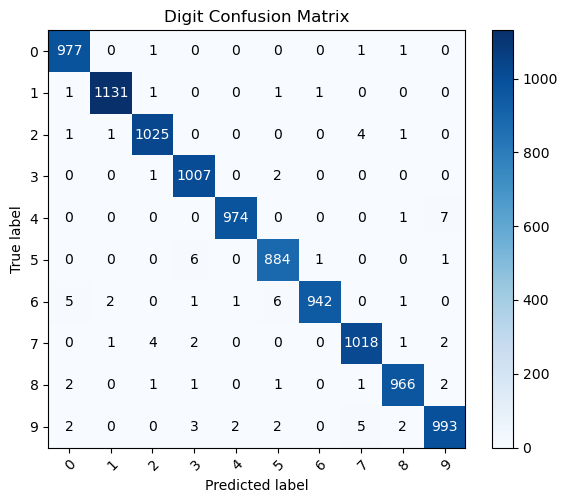

<Figure size 640x480 with 0 Axes>

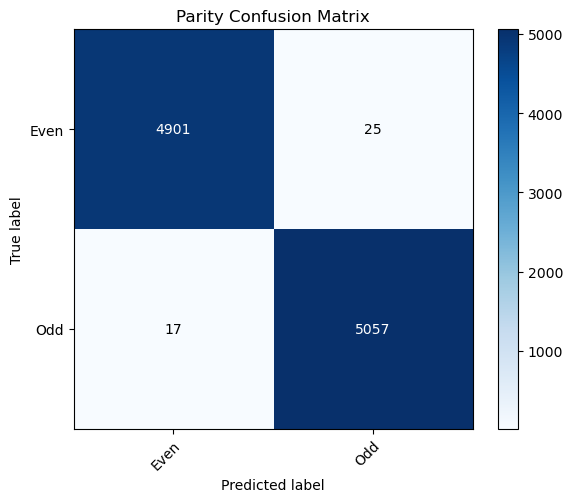

In [15]:
test_loss, accuracy_digit, accuracy_parity, misclassified_images, misclassified_labels, misclassified_preds = test_model(model, test_loader, device, criterion_digit, criterion_parity)

In [16]:
# Function to display images
def imshow(img, title):
    img = img / 2 + 0.5
    
    # Convert the image tensor to a numpy array
    npimg = img.numpy()
    
    # Transpose the dimensions to match matplotlib's expected format
    # From (channels, height, width) to (height, width, channels)
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    
    # Set the title of the plot
    plt.title(title)
    
    # Display the image
    plt.show()

This function, `imshow`, is designed to display a single image from the MNIST dataset.

Function Definition

- **`def imshow(img, title):`**
  - Defines a function named `imshow` that takes two parameters:
    - `img`: The image tensor to be displayed.
    - `title`: A string to be used as the title of the plot.

Image Processing

- **`img = img / 2 + 0.5`**
  - Purpose: Denormalizes the image data.
  - Explanation:
    - During preprocessing, images were normalized to the range [-1, 1].
    - This step scales the values back to the range [0, 1], which is suitable for display.
    - The operation is equivalent to reversing the normalization: `(img * 0.3081) + 0.1307`.

- **`npimg = img.numpy()`**
  - Converts the PyTorch tensor to a NumPy array.
  - This is necessary because matplotlib works with NumPy arrays, not PyTorch tensors.

Image Display

- **`plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')`**
  - Displays the image using matplotlib.
  - `np.transpose(npimg, (1, 2, 0))`:
    - Rearranges the dimensions of the image array.
    - PyTorch tensors are typically in the format (C, H, W) (Channel, Height, Width).
    - Matplotlib expects images in (H, W, C) format.
    - For MNIST (grayscale), this effectively squeezes out the channel dimension.
  - `cmap='gray'`:
    - Specifies that the image should be displayed in grayscale.
    - Appropriate for MNIST images, which are single-channel (grayscale).

- **`plt.title(title)`**
  - Sets the title of the plot to the provided `title` string.
  - Useful for displaying information about the image (e.g., true label, predicted label).

- **`plt.show()`**
  - Renders the plot and displays it.

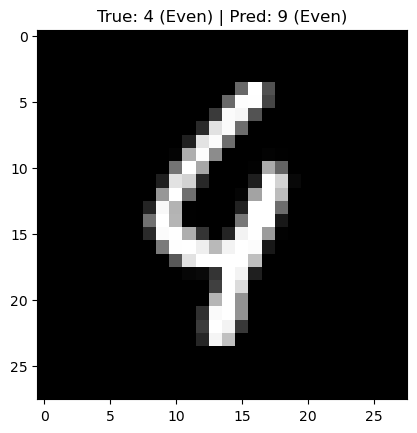

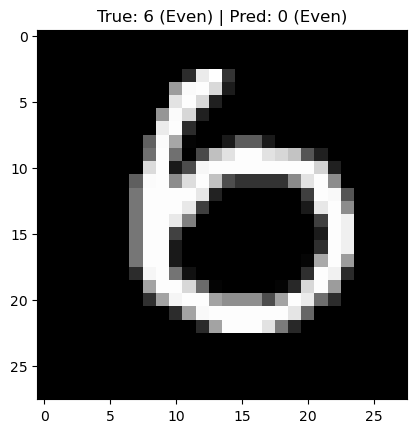

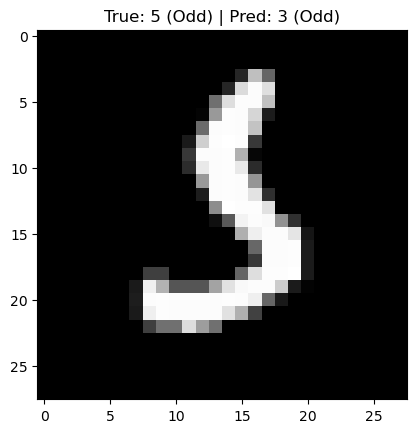

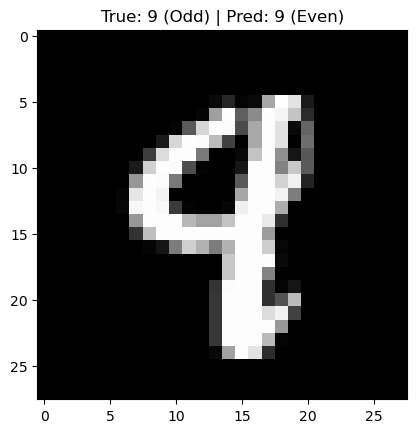

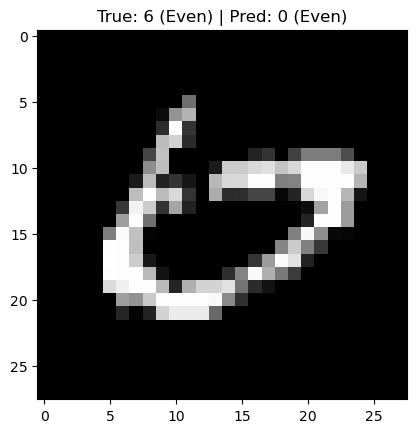

In [17]:
# Show a few misclassified images

for i in range(5):  # Loop through the first 5 misclassified images
    # Extract true labels and parities
    true_label, true_parity = misclassified_labels[i]
    
    # Extract predicted labels and parities
    pred_label, pred_parity = misclassified_preds[i]
    
    # Display the image using the custom imshow function
    imshow(misclassified_images[i],
           f'True: {true_label.item()} ({["Even", "Odd"][true_parity.item()]}) | '
           f'Pred: {pred_label.item()} ({["Even", "Odd"][pred_parity.item()]})')

This code snippet is responsible for displaying a selection of misclassified images from the test set, along with their true and predicted labels.

Loop Structure

- **`for i in range(5):`**
  - Iterates through the first 5 misclassified images.
  - The number 5 is arbitrary and can be adjusted to display more or fewer images.

Data Extraction

- **`true_label, true_parity = misclassified_labels[i]`**
  - Retrieves the true digit label and parity for the i-th misclassified image.
  - `misclassified_labels` is a list of tuples, each containing (digit, parity) for a misclassified image.

- **`pred_label, pred_parity = misclassified_preds[i]`**
  - Retrieves the predicted digit label and parity for the i-th misclassified image.
  - `misclassified_preds` is a list of tuples, each containing (predicted digit, predicted parity).

Image Display

- **`imshow(misclassified_images[i], ...)`**
  - Calls the `imshow` function defined earlier to display the image.
  - `misclassified_images[i]` is the tensor of the i-th misclassified image.

Title Formatting

- **`f'True: {true_label.item()} ({["Even", "Odd"][true_parity.item()]}) | Pred: {pred_label.item()} ({["Even", "Odd"][pred_parity.item()]})'`**
  - Creates a formatted string for the image title, including:
    - True label: The correct digit (0-9).
    - True parity: "Even" or "Odd" based on the true label.
    - Predicted label: The digit (0-9) predicted by the model.
    - Predicted parity: "Even" or "Odd" as predicted by the model.
  - `["Even", "Odd"][true_parity.item()]` and `["Even", "Odd"][pred_parity.item()]`:
    - Clever use of list indexing to convert binary parity (0 or 1) to "Even" or "Odd".
  - `.item()` is used to extract the scalar value from the PyTorch tensor.